In [1]:
import json
from collections import Counter
import pandas as pd
import os

C:\Users\omer\AppData\Local\Temp\ipykernel_8188\2938481424.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
stage_dict = {
    'stg_0100': 'Arena',
    'stg_0101': 'Arena Underground',
    'stg_0200': 'Urban Square',
    'stg_0201': 'Urban Square Evening',
    'stg_0300': 'Yakushima',
    'stg_0400': 'Coliseum of Fate',
    'stg_0500': 'Rebel Hangar',
    'stg_0700': 'Fallen Destiny',
    'stg_0900': 'Descent into Subconscious',
    'stg_1000': 'Sanctum',
    'stg_1100': 'Into the Stratosphere',
    'stg_1200': 'Ortiz Farm',
    'stg_1300': 'Celebration On The Seine',
    'stg_1400': 'Secluded Training Ground',
    'stg_1500': 'Elegant Palace',
    'stg_1600': 'Midnight Siege'
}


In [3]:
char_dict = {
	'chr_0000': 'Paul',
	'chr_0001': 'Law',
	'chr_0002': 'King',
	'chr_0003': 'Yoshimitsu',
	'chr_0004': 'Hwoarang',
	'chr_0005': 'Xiaoyu',
	'chr_0006': 'Jin',
	'chr_0007': 'Bryan',
	'chr_0008': 'Kazuya',
	'chr_0009': 'Steve',
	'chr_0010': 'Jack-8',
	'chr_0011': 'Asuka',
	'chr_0012': 'Devil Jin',
	'chr_0013': 'Feng',
	'chr_0014': 'Lili',
	'chr_0015': 'Dragunov',
	'chr_0016': 'Leo',
	'chr_0017': 'Lars',
	'chr_0018': 'Alisa',
	'chr_0019': 'Claudio',
	'chr_0020': 'Shaheen',
	'chr_0021': 'Nina',
	'chr_0022': 'Lee',
	'chr_0023': 'Kuma',
	'chr_0024': 'Panda',
	'chr_0028': 'Zafina',
	'chr_0029': 'Leroy',
	'chr_0032': 'Jun',
	'chr_0033': 'Reina',
	'chr_0034': 'Azucena',
	'chr_0035': 'Victor',
	'chr_0036': 'Raven'
}


In [4]:
battle_type_dict = {
    1: 'quick match',
    2: 'ranked match',
    3: 'group match',
    4: 'player match'
}

In [5]:
# There are only 3 unique platforms
# 3 is clearly pc
# 8 and 9 are console
# 8 is probably PS since it vastly outnumbers 9 approx 37 : 6
# 9 is probably Xbox
platform = {
    3: 'pc',
    8: 'console/PS?', # PS?
    9: 'console/XBOX?', # Xbox?
}

In [6]:
# Example of a match
# {
#     "battleId": "f7c4c3ba9d9d4484a14d08c9eb1e1f9a",
#     "battleType": 2,
#     "gameVersion": 10104,
#     "winResult": 2,
#     "totalRoundNum": 4,
#     "battleAt": 1707948450,
#     "viewNum": 0,
#     "stageId": "stg_1600",
#     "highlightFlag": false,
#     "1pUserId": "023591240125230934",
#     "1pPlayerName": "Shadowmane",
#     "1pPolarisId": "33Ge2NF493EJ",
#     "1pOnlineId": "Ghetto63zoo",
#     "1pNgWordFlag": 0,
#     "1pPlatform": 8,
#     "1pRank": 13,
#     "1pTekkenPower": 92575,
#     "1pCharaId": "chr_0029",
#     "1pWinRoundNum": 1,
#     "1pTagType01": 0,
#     "1pTagType02": 0,
#     "1pTagType03": 0,
#     "2pUserId": "894212240204104936",
#     "2pPlayerName": "Ramma",
#     "2pPolarisId": "3dJhi33AmJHn",
#     "2pOnlineId": "Ramazan123-",
#     "2pNgWordFlag": 0,
#     "2pPlatform": 8,
#     "2pRank": 10,
#     "2pTekkenPower": 74847,
#     "2pCharaId": "chr_0006",
#     "2pWinRoundNum": 3,
#     "2pTagType01": 0,
#     "2pTagType02": 0,
#     "2pTagType03": 0
# },

In [7]:
folder_path = './complete_JSONS'
master_list = []

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        print(f'Processing file: {filename}')
        file_path = os.path.join(folder_path, filename)
        
        # Load the JSON file
        with open(file_path) as f:
            data = json.load(f)
        
        # Get the length of replayDetailList
        replay_detail_list_length = len(data['replayDetailList'])
        master_list.extend(data['replayDetailList'])  # Combine the lengths into the master list

# Print the lengths of replayDetailList for each JSON file
print('Total length:', len(master_list))


Processing file: 1707944948_4.json
Processing file: 1707945059_4.json
Processing file: 1707945091_4.json
Processing file: 1707945107_4.json
Processing file: 1707945435_7.json
Processing file: 1707945441_12.json
Processing file: 1707945448_15.json
Processing file: 1707945505_3.json
Processing file: 1707947225_7.json
Processing file: 1707947900_6.json
Processing file: 1707948519_17.json
Processing file: 1707948525_20.json
Processing file: 1707948533_24.json
Processing file: 1707948827_6.json
Processing file: 1707948906_6.json
Processing file: 1707949000_6.json
Processing file: 1708004950_1.json
Processing file: 1708004999_1.json
Processing file: 1708005179_1.json
Processing file: 1708005359_1.json
Processing file: 1708005539_1.json
Processing file: 1708005719_1.json
Processing file: 1708005899_1.json
Processing file: 1708006079_1.json
Processing file: 1708006259_1.json
Processing file: 1708006439_1.json
Processing file: 1708006619_1.json
Processing file: 1708006799_1.json
Processing file

In [8]:
# Create a dictionary to store unique battleId values
unique_battle_ids = {}

# Create a new list to store the unique entries
unique_master_list = []

# Iterate over the master_list
for entry in master_list:
    battle_id = entry['battleId']
    
    # Check if the battleId is already in the dictionary
    if battle_id not in unique_battle_ids:
        # If it is not a duplicate, add the entry to the unique_master_list
        unique_master_list.append(entry)
        
        # Add the battleId to the dictionary
        unique_battle_ids[battle_id] = True

# Update the master_list with the unique entries
master_list = unique_master_list

print('Unique length:', len(master_list))

Unique length: 69930


In [9]:
# let's count how many players are on each platform
platform_counter = Counter()
for entry in master_list:
    platform_counter[platform[entry['1pPlatform']]] += 1
    platform_counter[platform[entry['2pPlatform']]] += 1

print(platform_counter)

Counter({'pc': 85727, 'console/PS?': 47759, 'console/XBOX?': 6374})


<Axes: title={'center': 'Character Counts'}, xlabel='Character Name'>

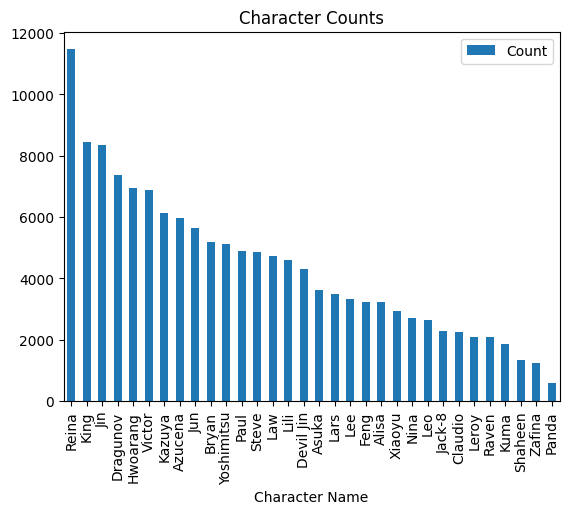

In [10]:
# Extract the charaId values from the master_list for 1p and 2p
chara_ids_1p = [entry['1pCharaId'] for entry in master_list]
chara_ids_2p = [entry['2pCharaId'] for entry in master_list]

# Join the two lists
chara_ids_1p.extend(chara_ids_2p)

# Sort the charaId values for 1p and 2p
chara_ids_1p.sort()

# Count the instances of each charaId for 1p and 2p
chara_id_counts_1p = Counter(chara_ids_1p)

# Translate charaId to character names
chara_names_1p = [char_dict[chara_id] for chara_id in chara_ids_1p]

# Plot the charaId counts with human-readable character names
chara_id_counts_1p_df = pd.DataFrame(chara_id_counts_1p.items(), columns=['CharaId', 'Count'])
chara_id_counts_1p_df['Character Name'] = chara_id_counts_1p_df['CharaId'].map(char_dict)
chara_id_counts_1p_df = chara_id_counts_1p_df.sort_values('Count', ascending=False)
chara_id_counts_1p_df.plot(kind='bar', x='Character Name', y='Count', title='Character Counts')

Rank Counts:
Rank: 0, Count: 7442
Rank: 1, Count: 1718
Rank: 2, Count: 2355
Rank: 3, Count: 3709
Rank: 4, Count: 3764
Rank: 5, Count: 3740
Rank: 6, Count: 5473
Rank: 7, Count: 3760
Rank: 8, Count: 6005
Rank: 9, Count: 8998
Rank: 10, Count: 7721
Rank: 11, Count: 8035
Rank: 12, Count: 11668
Rank: 13, Count: 9271
Rank: 14, Count: 9450
Rank: 15, Count: 15009
Rank: 16, Count: 7878
Rank: 17, Count: 6451
Rank: 18, Count: 5962
Rank: 19, Count: 3615
Rank: 20, Count: 2685
Rank: 21, Count: 2358
Rank: 22, Count: 1072
Rank: 23, Count: 718
Rank: 24, Count: 496
Rank: 25, Count: 287
Rank: 26, Count: 115
Rank: 27, Count: 73
Rank: 28, Count: 26
Rank: 29, Count: 6


<Axes: title={'center': 'Tekken 8 Rank Player Counts'}, xlabel='Dan'>

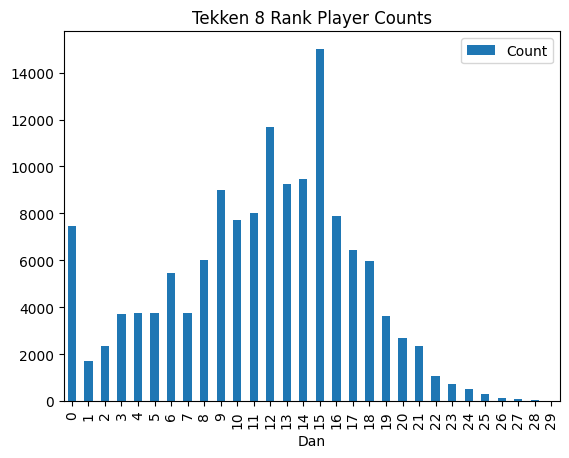

In [11]:
# Extract the rank values from the master_list for 1p and 2p
ranks_1p = [entry['1pRank'] for entry in master_list]
ranks_2p = [entry['2pRank'] for entry in master_list]

# Join the two lists
ranks_1p.extend(ranks_2p)

ranks = ranks_1p
# Sort the rank values for 1p and 2p
ranks.sort()

# Count the instances of each rank for 1p and 2p
rank_counts = Counter(ranks)

# Print the rank counts for 1p
print("Rank Counts:")
for rank, count in rank_counts.items():
    print(f"Rank: {rank}, Count: {count}")


# Create a bar chart of the rank counts
rank_counts_df = pd.DataFrame(rank_counts.items(), columns=['Dan', 'Count'])
rank_counts_df = rank_counts_df.sort_values(by='Dan')
rank_counts_df.plot(kind='bar', x='Dan', y='Count', title='Tekken 8 Rank Player Counts')


<Axes: title={'center': 'Character Win Rate'}, xlabel='Character Name'>

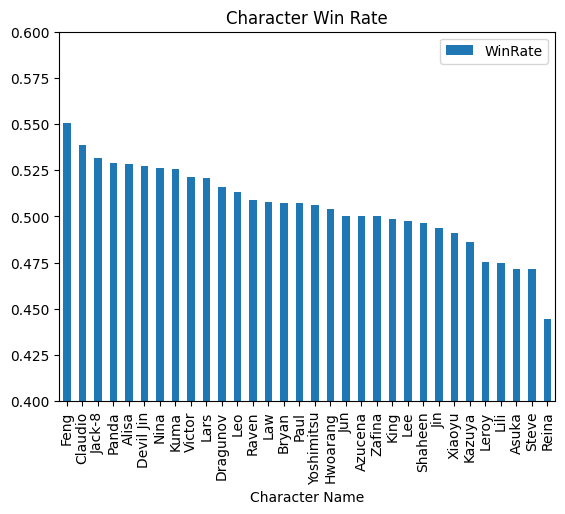

In [12]:
# calculate the win rate for each character
win_rate = {}
for chara_id in chara_id_counts_1p.keys():
    win_rate[chara_id] = 0

for entry in master_list:
    if entry['winResult'] == 1:
        win_rate[entry['1pCharaId']] += 1
    else:
        win_rate[entry['2pCharaId']] += 1

for chara_id in win_rate.keys():
    win_rate[chara_id] = win_rate[chara_id] / chara_id_counts_1p[chara_id]

# convert the chara_id to character name
win_rate_df = pd.DataFrame(win_rate.items(), columns=['CharaId', 'WinRate'])
win_rate_df['Character Name'] = win_rate_df['CharaId'].map(char_dict)
win_rate_df = win_rate_df.sort_values('WinRate', ascending=False)
win_rate_df.plot(kind='bar', x='Character Name', y='WinRate', title='Character Win Rate', ylim=(0.4, 0.6))


In [13]:
win_rate_df

,CharaId,WinRate,Character Name
13,chr_0013,0.550635,Feng
19,chr_0019,0.538632,Claudio
10,chr_0010,0.531607,Jack-8
24,chr_0024,0.529022,Panda
18,chr_0018,0.528261,Alisa
12,chr_0012,0.527294,Devil Jin
21,chr_0021,0.526316,Nina
23,chr_0023,0.525469,Kuma
30,chr_0035,0.521537,Victor
17,chr_0017,0.520744,Lars
